In [3]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits
import healpy as hp

from multiprocessing import Pool
from IPython.display import Image, display

sys.path.append(os.path.expanduser('~/git/desi-examples/imaging_systematics'))
from plot_healpix_map import plot_map

nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

In [4]:
def hlmean(data, maxpairs=1e8, random_seed=None, verbose=True):
    '''
    Hodges-Lehmann estimator.
    '''

    import itertools

    maxpairs = int(maxpairs)
    ndata = len(data)

    if ndata==0:
        if verbose: print('H-L mean: empty array!!!')
        return None
    if ndata==1:
        return data[0]
    if ndata*(ndata-1)/2 <= maxpairs:
        # only non-identical indices are included
        idx1, idx2 = np.array(list(itertools.combinations(np.arange(ndata), 2))).transpose()
        pairmean1 = (data[idx1]+data[idx2])/2.
        # the pairwise mean of identical indices
        pairmean2 = data
        pairmean = np.concatenate([pairmean1, pairmean2])
        hlmean_value = np.median(pairmean)
    else:
        if verbose: print('Too many pairs; only computing {:g} pairs'.format(maxpairs))
        if random_seed is not None:
            np.random.seed(random_seed)
        idx1, idx2 = np.random.choice(ndata, size=(maxpairs, 2)).transpose()
        pairmean = (data[idx1]+data[idx2])/2.
        hlmean_value = np.median(pairmean)

    return(hlmean_value)

In [5]:
nside = 256

r = {'g_south': 3.214, 'r_south': 2.165, 'z_south': 1.211, 'g_north': 3.258, 'r_north': 2.176, 'z_north': 1.199}

In [6]:
# Use the South as reference
field ='south'
maps = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/desi_stars/maps/drz_map_{}_{}.fits'.format(field, nside)))
print(len(maps), np.sum(maps['n_star']))
maps0 = maps[['HPXPIXEL', 'delta_rz_wmean', 'delta_rz_mean', 'delta_rz_median', 'n_star']].copy()
renorm = 1/(r['r_south']-r['z_south'])*(r['r_north']-r['z_north'])
maps0['delta_rz_wmean_renorm'] = maps0['delta_rz_wmean'] * renorm
maps0['delta_rz_mean_renorm'] = maps0['delta_rz_mean'] * renorm
maps0['delta_rz_median_renorm'] = maps0['delta_rz_median'] * renorm
maps0.rename_columns(['delta_rz_wmean_renorm', 'delta_rz_mean_renorm', 'delta_rz_median_renorm', 'n_star'], ['ref_delta_rz_wmean', 'ref_delta_rz_mean', 'ref_delta_rz_median', 'ref_n_star'])
maps0 = maps0[['HPXPIXEL', 'ref_delta_rz_wmean', 'ref_delta_rz_mean', 'ref_delta_rz_median', 'ref_n_star']]

field ='north'
maps = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/desi_stars/maps/drz_map_{}_{}.fits'.format(field, nside)))
print(len(maps), np.sum(maps['n_star']))
# remove the DEC=0 regions from the north
maps['RA'], maps['DEC'] = hp.pix2ang(nside, maps['HPXPIXEL'], nest=False, lonlat=True)
mask = maps['DEC']>25
maps = maps[mask]

184690 1786279
81815 575278


In [7]:
original_size, original_n_tot_star = len(maps), np.sum(maps['n_star'])
maps = join(maps, maps0, join_type='inner', keys='HPXPIXEL')
print('Fraction of pixels remaining: {:.1f}%'.format(100*len(maps)/original_size))
print('Fraction of stars remaining: {:.1f}%'.format(100*np.sum(maps['n_star'])/original_n_tot_star))

Fraction of pixels remaining: 6.8%
Fraction of stars remaining: 7.4%


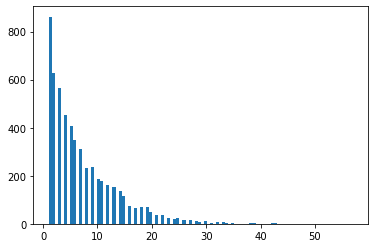

In [8]:
plt.hist(np.minimum(maps['n_star'], maps['ref_n_star']), 100)
plt.show()

In [14]:
n_star_min = 4

0.6295294753921038


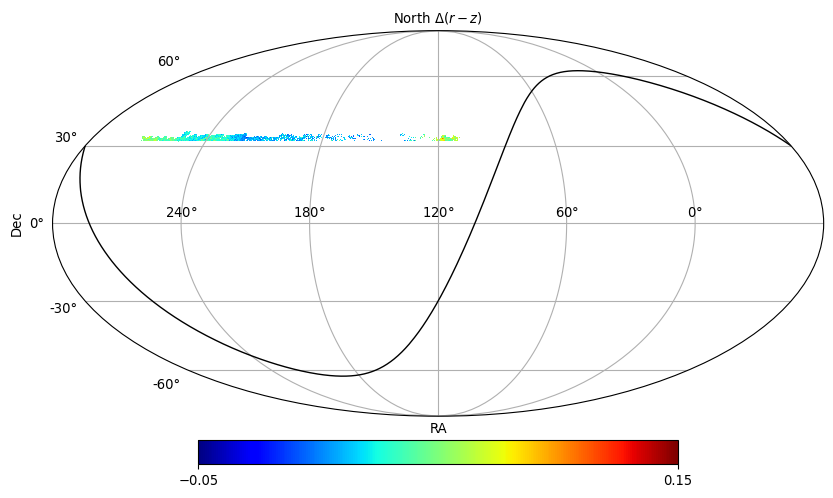

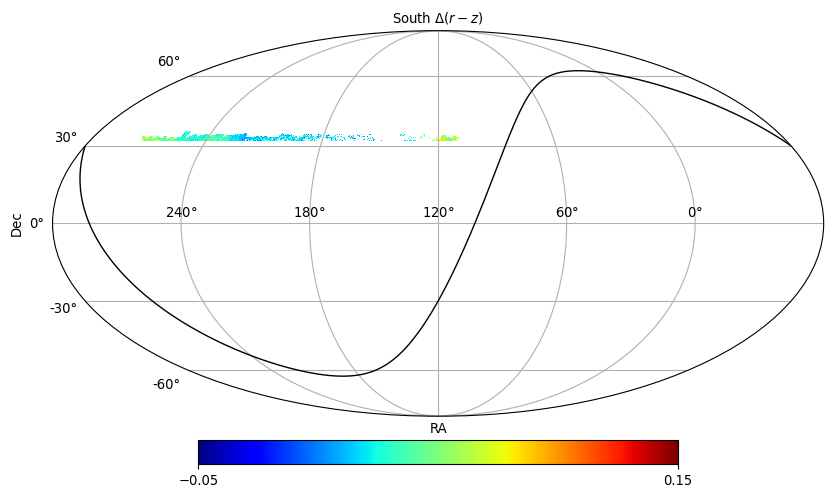

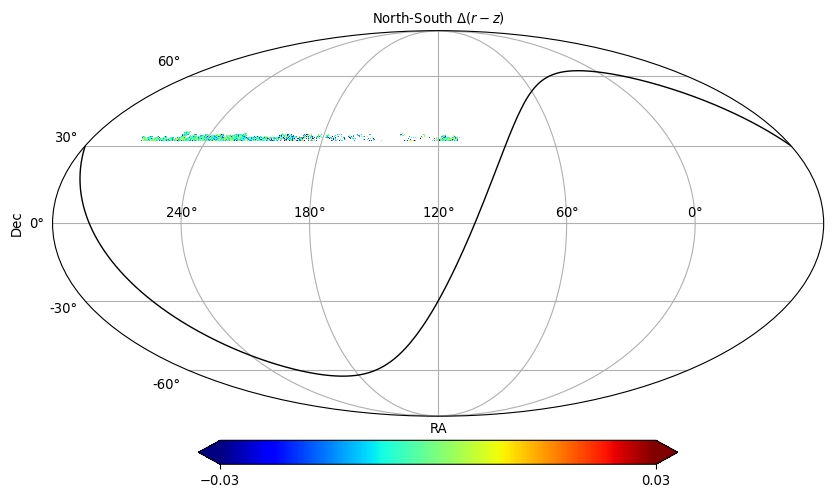

In [10]:
mask = (maps['n_star']>=n_star_min) & (maps['ref_n_star']>=n_star_min)
print(np.sum(mask)/len(mask))

plot_map(nside, maps['delta_rz_wmean'][mask], maps['HPXPIXEL'][mask],
         vmin=-0.05, vmax=0.15, cmap='jet',
         title='North $\Delta(r-z)$', save_path='tmp.png', show=False, xsize=1500, dpi=100, timing=False)
display(Image("tmp.png"))

plot_map(nside, maps['ref_delta_rz_wmean'][mask], maps['HPXPIXEL'][mask],
         vmin=-0.05, vmax=0.15, cmap='jet',
         title='South $\Delta(r-z)$', save_path='tmp.png', show=False, xsize=1500, dpi=100, timing=False)
display(Image("tmp.png"))

plot_map(nside, (maps['delta_rz_wmean']-maps['ref_delta_rz_wmean'])[mask], maps['HPXPIXEL'][mask],
         vmin=-0.03, vmax=0.03, cmap='jet',
         title='North-South $\Delta(r-z)$', save_path='tmp.png', show=False, xsize=1500, dpi=100, timing=False)
display(Image("tmp.png"))

0.6295294753921038


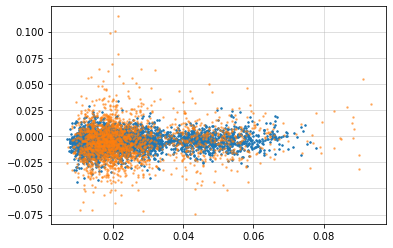

In [12]:
mask = (maps['n_star']>=n_star_min) & (maps['ref_n_star']>=n_star_min)
print(np.sum(mask)/len(mask))
plt.plot(maps['EBV_SFD'][mask], (maps['delta_rz_wmean']-maps['ref_delta_rz_wmean'])[mask], '.', ms=3)
plt.plot(maps['EBV_SFD'][~mask], (maps['delta_rz_wmean']-maps['ref_delta_rz_wmean'])[~mask], '.', ms=3, alpha=0.5)
plt.grid(alpha=0.5)
plt.show()

Pixels remaining after n_star cut: 3492 (63.0%)
RMS: 8.3 mmag;  NMAD: 7.5 mmag


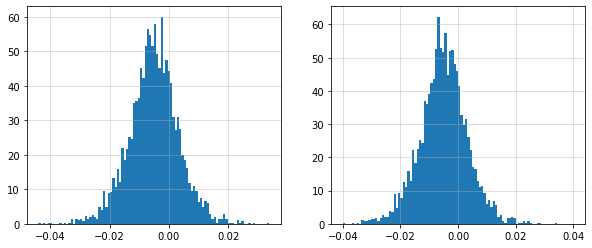

Offset:
mean = -5.09 mmag;  H-L mean = -5.04 mmag;  median = -5.00 mmag
Uncertainty = 0.14 mmag



In [16]:
mask = (maps['n_star']>=n_star_min) & (maps['ref_n_star']>=n_star_min)
print('Pixels remaining after n_star cut: {} ({:.1f}%)'.format(np.sum(mask), 100*np.sum(mask)/len(mask)))

diff = (maps['delta_rz_wmean']-maps['ref_delta_rz_wmean'])[mask]
print('RMS: {:.1f} mmag;  NMAD: {:.1f} mmag'.format(1000*np.std(diff), 1000*nmad(diff)))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(diff, 100, density=True)
axes[0].grid(alpha=0.5)
axes[1].hist(diff, 100, range=(-0.04, 0.04), density=True)
axes[1].grid(alpha=0.5)
plt.show()

print('Offset:')
print('mean = {:.2f} mmag;  H-L mean = {:.2f} mmag;  median = {:.2f} mmag'.format(np.mean(diff)*1000, hlmean(diff)*1000, np.median(diff)*1000))
print('Uncertainty = {:.2f} mmag'.format(1000*np.std(diff)/np.sqrt(len(diff))))
print()

Pixels remaining after n_star cut: 3492 (63.0%)
Pixels remaining after n_star + EBV cut: 3165 (57.1%)
RMS: 8.3 mmag;  NMAD: 7.4 mmag


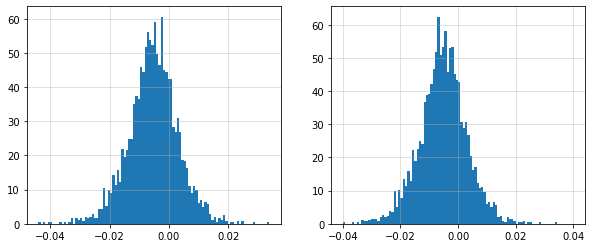

Offset:
mean = -5.30 mmag;  H-L mean = -5.21 mmag;  median = -5.15 mmag
Uncertainty = 0.15 mmag



In [22]:
mask = (maps['n_star']>=n_star_min) & (maps['ref_n_star']>=n_star_min)
print('Pixels remaining after n_star cut: {} ({:.1f}%)'.format(np.sum(mask), 100*np.sum(mask)/len(mask)))

mask &= maps['EBV_SFD']<0.05
print('Pixels remaining after n_star + EBV cut: {} ({:.1f}%)'.format(np.sum(mask), 100*np.sum(mask)/len(mask)))

diff = (maps['delta_rz_wmean']-maps['ref_delta_rz_wmean'])[mask]
print('RMS: {:.1f} mmag;  NMAD: {:.1f} mmag'.format(1000*np.std(diff), 1000*nmad(diff)))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(diff, 100, density=True)
axes[0].grid(alpha=0.5)
axes[1].hist(diff, 100, range=(-0.04, 0.04), density=True)
axes[1].grid(alpha=0.5)
plt.show()

print('Offset:')
print('mean = {:.2f} mmag;  H-L mean = {:.2f} mmag;  median = {:.2f} mmag'.format(np.mean(diff)*1000, hlmean(diff)*1000, np.median(diff)*1000))
print('Uncertainty = {:.2f} mmag'.format(1000*np.std(diff)/np.sqrt(len(diff))))
print()